> Run this network: https://colab.research.google.com/drive/1qlewMtxcAJT6fIJdmMh8pSf2e-dh51Rw

> Fix the network above:

*   change the code such that it uses GPU and
*   change the architecture to C1C2C3C40 (No MaxPooling, but 3 3x3 layers with stride of 2 instead) (If you can figure out how to use Dilated kernels here instead of MP or strided convolution, extra credits!)
*   total RF must be more than 44
*   one of the layers must use Depthwise Separable Convolution
*   one of the layers must use Dilated Convolution
*   use GAP (compulsory):- add FC after GAP to target #of classes (optional)
*   use albumentation library and apply:

   > horizontal flip

   > shiftScaleRotate

    > coarseDropout (max_holes = 1, max_height=16px, max_width=1, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
*   achieve 85% accuracy, as many epochs as you want. Total Params to be less than 200k.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb  2 13:21:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##  Install the EVA8 packages, hosted @ github

In [2]:
!pip install git+https://git@github.com/ojhajayant/EVA8.git --upgrade 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/ojhajayant/EVA8.git to /tmp/pip-req-build-_qfd7otz
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/ojhajayant/EVA8.git' /tmp/pip-req-build-_qfd7otz
  Resolved https://****@github.com/ojhajayant/EVA8.git to commit 46f52015e1e9128a2d0c070be90b57d5e4d0f7a0
  Preparing metadata (setup.py) ... done
  Created wheel for eva8: filename=eva8-0.0.0-py3-none-any.whl size=17727 sha256=765cceb8cbd243c03daa79b495d5c3ed20d649d1c759ba6e5c6f51c2d86916bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ktyjweq/wheels/91/2b/81/6528ca90c705fbe7f126306baa4c34cd2cbf0ea8fcb5a3dd90
Successfully built eva8


In [3]:
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 65.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.68
    Uninstalling opencv-python-headless-4.7.0.68:
      Successfully uninstalled opencv-python-headless-4.7.0.68


In [4]:
!pip install albumentations --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 KB 4.2 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


# Import Libraries

In [5]:
from __future__ import print_function

import os
import sys
import warnings
import cv2

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary

from session_6.modular import cfg
from session_6.modular import preprocess
from session_6.modular import preprocess_albumentations
from session_6.modular import test
from session_6.modular import train
from session_6.modular import utils
from session_6.modular.models import model
from torch.optim.lr_scheduler import StepLR

sys.path.append('./')
global args
args = cfg.args
args.IPYNB_ENV = True
#Use albumentations lib for image-augmentation
#if below flag is false, usual torchvision 
#transforms are applied.
args.use_albumentations = True
img_size = (32,32)

### Save the config file, with all default/provided/required configuration

In [6]:
#print("The config used for this run are being saved @ {}".format(os.path.join(args.prefix, 'config_params.txt')))
#utils.write(vars(args), os.path.join(args.prefix, 'config_params.txt'))

### Calculate mean & std for Normalization

In [7]:
args.dataset = 'CIFAR10'
mean, std = preprocess.get_dataset_mean_std()
mean_tuple = (mean[0], mean[1], mean[2])
std_tuple = (std[0], std[1], std[2])

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


###  Dataloader Arguments & Test/Train Dataloaders

In [8]:
if np.ndim(mean) ==0:
    if args.use_albumentations:
        train_dataset, test_dataset, train_loader, test_loader = preprocess.preprocess_data((mean,), (std,))
    else:
        train_dataset, test_dataset, train_loader, test_loader = preprocess.preprocess_data_albumentations((mean,), (std,), img_size)    
else:
    if args.use_albumentations:
        print("Using albumentation lib for image-augmentation & other transforms")
        train_dataset, test_dataset, train_loader, test_loader = \
            preprocess_albumentations.preprocess_data_albumentations(mean_tuple, std_tuple, img_size)
    else:
        print("Using torchvison for image-augmentation & other transforms")
        train_dataset, test_dataset, train_loader, test_loader = preprocess.preprocess_data(mean_tuple, std_tuple)

Using albumentation lib for image-augmentation & other transforms
************
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


### Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Stats from Train Data]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
[Stats from Test Data]
 - Numpy Shape: (10000, 32, 32, 3)
 - Tensor Shape: torch.Size([10000, 32, 32, 3])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)


torch.Size([64, 3, 32, 32])
torch.Size([64])
Saving plot for a sample to ascertain RF required for edges & gradient /content/./data/data_stats.png


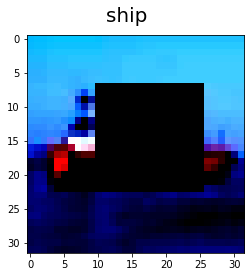

In [9]:
preprocess.get_data_stats(train_dataset, test_dataset, train_loader)

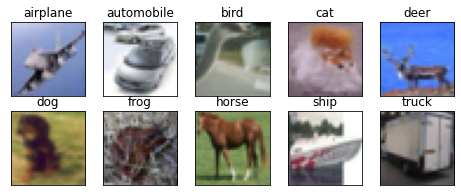

In [10]:
utils.plot_train_samples(train_loader)

### Using L1-regularization here 
(l1_weight = 0.000025, started out reusing some older assignment values, but works OK here too)

In [11]:
L1 = args.L1   
print("L1:", L1)
L2 = args.L2   
print("L2:", L2)

L1: True
L2: False


### detect the device being run on

In [12]:
device = torch.device("cuda" if args.cuda else "cpu")
print(device)

cuda


### Get the model loaded with summary

In [13]:
# from session_6.modular.models import EVA8_session6_assignment_model EVA8_session6_assignment_model
from session_6.modular.models.model import EVA8_session6_assignment_model
model = EVA8_session6_assignment_model()
model = model.to(device)
if args.dataset == 'CIFAR10':
    summary(model, input_size=(3, 32, 32))
elif args.dataset == 'MNIST':
    summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              27
            Conv2d-2           [-1, 64, 32, 32]             192
   SeparableConv2d-3           [-1, 64, 32, 32]               0
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 16, 16]             576
            Conv2d-8          [-1, 128, 16, 16]           8,192
   SeparableConv2d-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
          Dropout-11          [-1, 128, 16, 16]               0
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]             128
           Conv2d-14           [-1, 64,

## Training and Testing

Model training starts on CIFAR10 dataset
EPOCH: 1
LR: 0.07


Loss=1.8026986122131348 Batch_id=781 Accuracy=35.19: 100%|██████████| 782/782 [00:10<00:00, 74.36it/s]



Test set: Average loss: 1.4972, Accuracy: 4607/10000 (46.07%)

validation-accuracy improved from 0 to 46.07, saving model to /content/./saved_models/CIFAR10_model_epoch-1_L1-1_L2-0_val_acc-46.07.h5
EPOCH: 2
LR: 0.06875


Loss=1.38417649269104 Batch_id=781 Accuracy=48.13: 100%|██████████| 782/782 [00:09<00:00, 79.34it/s]



Test set: Average loss: 1.1724, Accuracy: 5791/10000 (57.91%)

validation-accuracy improved from 46.07 to 57.91, saving model to /content/./saved_models/CIFAR10_model_epoch-2_L1-1_L2-0_val_acc-57.91.h5
EPOCH: 3
LR: 0.06752232142857142


Loss=1.4178071022033691 Batch_id=781 Accuracy=53.88: 100%|██████████| 782/782 [00:09<00:00, 79.55it/s]



Test set: Average loss: 1.0993, Accuracy: 6048/10000 (60.48%)

validation-accuracy improved from 57.91 to 60.48, saving model to /content/./saved_models/CIFAR10_model_epoch-3_L1-1_L2-0_val_acc-60.48.h5
EPOCH: 4
LR: 0.0663165656887755


Loss=1.1230255365371704 Batch_id=781 Accuracy=57.81: 100%|██████████| 782/782 [00:09<00:00, 78.42it/s]



Test set: Average loss: 1.0121, Accuracy: 6344/10000 (63.44%)

validation-accuracy improved from 60.48 to 63.44, saving model to /content/./saved_models/CIFAR10_model_epoch-4_L1-1_L2-0_val_acc-63.44.h5
EPOCH: 5
LR: 0.06513234130147594


Loss=1.1846450567245483 Batch_id=781 Accuracy=60.66: 100%|██████████| 782/782 [00:10<00:00, 77.89it/s]



Test set: Average loss: 0.8838, Accuracy: 6935/10000 (69.35%)

validation-accuracy improved from 63.44 to 69.35, saving model to /content/./saved_models/CIFAR10_model_epoch-5_L1-1_L2-0_val_acc-69.35.h5
EPOCH: 6
LR: 0.0639692637782353


Loss=1.0759468078613281 Batch_id=781 Accuracy=62.71: 100%|██████████| 782/782 [00:10<00:00, 77.58it/s]



Test set: Average loss: 0.8093, Accuracy: 7169/10000 (71.69%)

validation-accuracy improved from 69.35 to 71.69, saving model to /content/./saved_models/CIFAR10_model_epoch-6_L1-1_L2-0_val_acc-71.69.h5
EPOCH: 7
LR: 0.0628269554964811


Loss=0.8482896089553833 Batch_id=781 Accuracy=64.54: 100%|██████████| 782/782 [00:09<00:00, 80.01it/s]



Test set: Average loss: 0.8128, Accuracy: 7164/10000 (71.64%)

EPOCH: 8
LR: 0.061705045576901076


Loss=1.1482986211776733 Batch_id=781 Accuracy=66.30: 100%|██████████| 782/782 [00:10<00:00, 75.58it/s]



Test set: Average loss: 0.7569, Accuracy: 7393/10000 (73.93%)

validation-accuracy improved from 71.69 to 73.93, saving model to /content/./saved_models/CIFAR10_model_epoch-8_L1-1_L2-0_val_acc-73.93.h5
EPOCH: 9
LR: 0.06060316976302784


Loss=1.4681767225265503 Batch_id=781 Accuracy=66.83: 100%|██████████| 782/782 [00:10<00:00, 75.05it/s]



Test set: Average loss: 0.7814, Accuracy: 7317/10000 (73.17%)

EPOCH: 10
LR: 0.05952097030297377


Loss=1.6267794370651245 Batch_id=781 Accuracy=67.99: 100%|██████████| 782/782 [00:09<00:00, 78.95it/s]



Test set: Average loss: 0.6847, Accuracy: 7582/10000 (75.82%)

validation-accuracy improved from 73.93 to 75.82, saving model to /content/./saved_models/CIFAR10_model_epoch-10_L1-1_L2-0_val_acc-75.82.h5
EPOCH: 11
LR: 0.05845809583327781


Loss=1.1043760776519775 Batch_id=781 Accuracy=68.96: 100%|██████████| 782/782 [00:10<00:00, 77.55it/s]



Test set: Average loss: 0.6763, Accuracy: 7606/10000 (76.06%)

validation-accuracy improved from 75.82 to 76.06, saving model to /content/./saved_models/CIFAR10_model_epoch-11_L1-1_L2-0_val_acc-76.06.h5
EPOCH: 12
LR: 0.057414201264826416


Loss=1.2418785095214844 Batch_id=781 Accuracy=69.56: 100%|██████████| 782/782 [00:10<00:00, 77.79it/s]



Test set: Average loss: 0.6534, Accuracy: 7738/10000 (77.38%)

validation-accuracy improved from 76.06 to 77.38, saving model to /content/./saved_models/CIFAR10_model_epoch-12_L1-1_L2-0_val_acc-77.38.h5
EPOCH: 13
LR: 0.05638894767081166


Loss=1.1116430759429932 Batch_id=781 Accuracy=70.25: 100%|██████████| 782/782 [00:10<00:00, 75.87it/s]



Test set: Average loss: 0.6290, Accuracy: 7829/10000 (78.29%)

validation-accuracy improved from 77.38 to 78.29, saving model to /content/./saved_models/CIFAR10_model_epoch-13_L1-1_L2-0_val_acc-78.29.h5
EPOCH: 14
LR: 0.055382002176690016


Loss=0.5699455738067627 Batch_id=781 Accuracy=70.88: 100%|██████████| 782/782 [00:09<00:00, 78.71it/s]



Test set: Average loss: 0.6261, Accuracy: 7850/10000 (78.50%)

validation-accuracy improved from 78.29 to 78.5, saving model to /content/./saved_models/CIFAR10_model_epoch-14_L1-1_L2-0_val_acc-78.5.h5
EPOCH: 15
LR: 0.054393037852106266


Loss=1.213613748550415 Batch_id=781 Accuracy=71.18: 100%|██████████| 782/782 [00:09<00:00, 79.04it/s]



Test set: Average loss: 0.6311, Accuracy: 7854/10000 (78.54%)

validation-accuracy improved from 78.5 to 78.54, saving model to /content/./saved_models/CIFAR10_model_epoch-15_L1-1_L2-0_val_acc-78.54.h5
EPOCH: 16
LR: 0.053421733604747224


Loss=0.9226532578468323 Batch_id=781 Accuracy=71.84: 100%|██████████| 782/782 [00:09<00:00, 79.76it/s]



Test set: Average loss: 0.5991, Accuracy: 7916/10000 (79.16%)

validation-accuracy improved from 78.54 to 79.16, saving model to /content/./saved_models/CIFAR10_model_epoch-16_L1-1_L2-0_val_acc-79.16.h5
EPOCH: 17
LR: 0.05246777407609102


Loss=1.2119325399398804 Batch_id=781 Accuracy=71.94: 100%|██████████| 782/782 [00:10<00:00, 78.18it/s]



Test set: Average loss: 0.6463, Accuracy: 7780/10000 (77.80%)

EPOCH: 18
LR: 0.05153084953901796


Loss=1.0064668655395508 Batch_id=781 Accuracy=72.55: 100%|██████████| 782/782 [00:10<00:00, 77.40it/s]



Test set: Average loss: 0.5854, Accuracy: 7953/10000 (79.53%)

validation-accuracy improved from 79.16 to 79.53, saving model to /content/./saved_models/CIFAR10_model_epoch-18_L1-1_L2-0_val_acc-79.53.h5
EPOCH: 19
LR: 0.05061065579724978


Loss=1.033732295036316 Batch_id=781 Accuracy=73.08: 100%|██████████| 782/782 [00:09<00:00, 78.91it/s]



Test set: Average loss: 0.5984, Accuracy: 7928/10000 (79.28%)

EPOCH: 20
LR: 0.0497068940865846


Loss=0.7709851264953613 Batch_id=781 Accuracy=73.06: 100%|██████████| 782/782 [00:09<00:00, 78.70it/s]



Test set: Average loss: 0.5658, Accuracy: 8058/10000 (80.58%)

validation-accuracy improved from 79.53 to 80.58, saving model to /content/./saved_models/CIFAR10_model_epoch-20_L1-1_L2-0_val_acc-80.58.h5
EPOCH: 21
LR: 0.04881927097789559


Loss=0.7774319648742676 Batch_id=781 Accuracy=73.53: 100%|██████████| 782/782 [00:09<00:00, 79.01it/s]



Test set: Average loss: 0.5577, Accuracy: 8059/10000 (80.59%)

validation-accuracy improved from 80.58 to 80.59, saving model to /content/./saved_models/CIFAR10_model_epoch-21_L1-1_L2-0_val_acc-80.59.h5
EPOCH: 22
LR: 0.04794749828186173


Loss=0.8005102872848511 Batch_id=781 Accuracy=74.04: 100%|██████████| 782/782 [00:09<00:00, 78.79it/s]



Test set: Average loss: 0.5452, Accuracy: 8035/10000 (80.35%)

EPOCH: 23
LR: 0.04709129295539991


Loss=0.8750649094581604 Batch_id=781 Accuracy=74.14: 100%|██████████| 782/782 [00:09<00:00, 78.98it/s]



Test set: Average loss: 0.5507, Accuracy: 8097/10000 (80.97%)

validation-accuracy improved from 80.59 to 80.97, saving model to /content/./saved_models/CIFAR10_model_epoch-23_L1-1_L2-0_val_acc-80.97.h5
EPOCH: 24
LR: 0.046250377009767765


Loss=1.1007106304168701 Batch_id=781 Accuracy=74.37: 100%|██████████| 782/782 [00:10<00:00, 78.06it/s]



Test set: Average loss: 0.5376, Accuracy: 8158/10000 (81.58%)

validation-accuracy improved from 80.97 to 81.58, saving model to /content/./saved_models/CIFAR10_model_epoch-24_L1-1_L2-0_val_acc-81.58.h5
EPOCH: 25
LR: 0.04542447742030763


Loss=0.884267270565033 Batch_id=781 Accuracy=74.54: 100%|██████████| 782/782 [00:09<00:00, 79.45it/s]



Test set: Average loss: 0.5935, Accuracy: 7981/10000 (79.81%)

EPOCH: 26
LR: 0.04461332603780213


Loss=0.4847167432308197 Batch_id=781 Accuracy=74.97: 100%|██████████| 782/782 [00:10<00:00, 76.12it/s]



Test set: Average loss: 0.5473, Accuracy: 8139/10000 (81.39%)

EPOCH: 27
LR: 0.04381665950141281


Loss=0.8832544684410095 Batch_id=781 Accuracy=75.10: 100%|██████████| 782/782 [00:10<00:00, 78.02it/s]



Test set: Average loss: 0.5199, Accuracy: 8184/10000 (81.84%)

validation-accuracy improved from 81.58 to 81.84, saving model to /content/./saved_models/CIFAR10_model_epoch-27_L1-1_L2-0_val_acc-81.84.h5
EPOCH: 28
LR: 0.04303421915317329


Loss=0.646289587020874 Batch_id=781 Accuracy=75.47: 100%|██████████| 782/782 [00:09<00:00, 78.36it/s]



Test set: Average loss: 0.5205, Accuracy: 8205/10000 (82.05%)

validation-accuracy improved from 81.84 to 82.05, saving model to /content/./saved_models/CIFAR10_model_epoch-28_L1-1_L2-0_val_acc-82.05.h5
EPOCH: 29
LR: 0.04226575095400948


Loss=0.6783645749092102 Batch_id=781 Accuracy=75.49: 100%|██████████| 782/782 [00:10<00:00, 77.56it/s]



Test set: Average loss: 0.5184, Accuracy: 8204/10000 (82.04%)

EPOCH: 30
LR: 0.04151100540125931


Loss=0.7089438438415527 Batch_id=781 Accuracy=75.71: 100%|██████████| 782/782 [00:10<00:00, 76.46it/s]



Test set: Average loss: 0.5336, Accuracy: 8142/10000 (81.42%)

EPOCH: 31
LR: 0.04076973744766539


Loss=1.3927870988845825 Batch_id=781 Accuracy=75.90: 100%|██████████| 782/782 [00:10<00:00, 77.68it/s]



Test set: Average loss: 0.5112, Accuracy: 8219/10000 (82.19%)

validation-accuracy improved from 82.05 to 82.19, saving model to /content/./saved_models/CIFAR10_model_epoch-31_L1-1_L2-0_val_acc-82.19.h5
EPOCH: 32
LR: 0.04004170642181422


Loss=1.2701869010925293 Batch_id=781 Accuracy=75.98: 100%|██████████| 782/782 [00:09<00:00, 78.65it/s]



Test set: Average loss: 0.5107, Accuracy: 8285/10000 (82.85%)

validation-accuracy improved from 82.19 to 82.85, saving model to /content/./saved_models/CIFAR10_model_epoch-32_L1-1_L2-0_val_acc-82.85.h5
EPOCH: 33
LR: 0.03932667594999611


Loss=0.6270047426223755 Batch_id=781 Accuracy=76.38: 100%|██████████| 782/782 [00:09<00:00, 78.55it/s]



Test set: Average loss: 0.5191, Accuracy: 8236/10000 (82.36%)

EPOCH: 34
LR: 0.03862441387946046


Loss=0.784419059753418 Batch_id=781 Accuracy=76.35: 100%|██████████| 782/782 [00:09<00:00, 78.52it/s]



Test set: Average loss: 0.5040, Accuracy: 8260/10000 (82.60%)

EPOCH: 35
LR: 0.03793469220304152


Loss=0.37007394433021545 Batch_id=781 Accuracy=76.41: 100%|██████████| 782/782 [00:09<00:00, 78.45it/s]



Test set: Average loss: 0.4957, Accuracy: 8297/10000 (82.97%)

validation-accuracy improved from 82.85 to 82.97, saving model to /content/./saved_models/CIFAR10_model_epoch-35_L1-1_L2-0_val_acc-82.97.h5
EPOCH: 36
LR: 0.03725728698513006


Loss=0.5447084307670593 Batch_id=781 Accuracy=76.63: 100%|██████████| 782/782 [00:09<00:00, 79.17it/s]



Test set: Average loss: 0.4957, Accuracy: 8278/10000 (82.78%)

EPOCH: 37
LR: 0.03659197828896702


Loss=0.9271879196166992 Batch_id=781 Accuracy=76.96: 100%|██████████| 782/782 [00:10<00:00, 77.11it/s]



Test set: Average loss: 0.5011, Accuracy: 8224/10000 (82.24%)

EPOCH: 38
LR: 0.035938550105235466


Loss=0.9885998368263245 Batch_id=781 Accuracy=77.16: 100%|██████████| 782/782 [00:10<00:00, 77.98it/s]



Test set: Average loss: 0.4818, Accuracy: 8330/10000 (83.30%)

validation-accuracy improved from 82.97 to 83.3, saving model to /content/./saved_models/CIFAR10_model_epoch-38_L1-1_L2-0_val_acc-83.3.h5
EPOCH: 39
LR: 0.03529679028192769


Loss=0.8854047060012817 Batch_id=781 Accuracy=77.15: 100%|██████████| 782/782 [00:10<00:00, 78.09it/s]



Test set: Average loss: 0.4804, Accuracy: 8372/10000 (83.72%)

validation-accuracy improved from 83.3 to 83.72, saving model to /content/./saved_models/CIFAR10_model_epoch-39_L1-1_L2-0_val_acc-83.72.h5
EPOCH: 40
LR: 0.034666490455464695


Loss=0.4807526767253876 Batch_id=781 Accuracy=77.39: 100%|██████████| 782/782 [00:10<00:00, 76.22it/s]



Test set: Average loss: 0.4785, Accuracy: 8327/10000 (83.27%)

EPOCH: 41
LR: 0.03404744598304568


Loss=0.8308233022689819 Batch_id=781 Accuracy=77.35: 100%|██████████| 782/782 [00:09<00:00, 78.26it/s]



Test set: Average loss: 0.4822, Accuracy: 8310/10000 (83.10%)

EPOCH: 42
LR: 0.03343945587620558


Loss=0.6176031827926636 Batch_id=781 Accuracy=77.49: 100%|██████████| 782/782 [00:10<00:00, 77.78it/s]



Test set: Average loss: 0.4748, Accuracy: 8367/10000 (83.67%)

EPOCH: 43
LR: 0.03284232273555905


Loss=0.7720434069633484 Batch_id=781 Accuracy=77.79: 100%|██████████| 782/782 [00:10<00:00, 76.58it/s]



Test set: Average loss: 0.4765, Accuracy: 8356/10000 (83.56%)

EPOCH: 44
LR: 0.03225585268670978


Loss=0.9203888773918152 Batch_id=781 Accuracy=77.78: 100%|██████████| 782/782 [00:09<00:00, 78.41it/s]



Test set: Average loss: 0.4778, Accuracy: 8353/10000 (83.53%)

EPOCH: 45
LR: 0.031679855317304245


Loss=0.46674153208732605 Batch_id=781 Accuracy=78.11: 100%|██████████| 782/782 [00:10<00:00, 77.61it/s]



Test set: Average loss: 0.4698, Accuracy: 8351/10000 (83.51%)

EPOCH: 46
LR: 0.031114143615209526


Loss=0.7740684151649475 Batch_id=781 Accuracy=77.88: 100%|██████████| 782/782 [00:10<00:00, 77.71it/s]



Test set: Average loss: 0.4707, Accuracy: 8381/10000 (83.81%)

validation-accuracy improved from 83.72 to 83.81, saving model to /content/./saved_models/CIFAR10_model_epoch-46_L1-1_L2-0_val_acc-83.81.h5
EPOCH: 47
LR: 0.030558533907795067


Loss=0.7905864715576172 Batch_id=781 Accuracy=78.32: 100%|██████████| 782/782 [00:10<00:00, 77.38it/s]



Test set: Average loss: 0.4731, Accuracy: 8375/10000 (83.75%)

EPOCH: 48
LR: 0.030012845802298724


Loss=0.7841664552688599 Batch_id=781 Accuracy=78.16: 100%|██████████| 782/782 [00:10<00:00, 76.82it/s]



Test set: Average loss: 0.4615, Accuracy: 8402/10000 (84.02%)

validation-accuracy improved from 83.81 to 84.02, saving model to /content/./saved_models/CIFAR10_model_epoch-48_L1-1_L2-0_val_acc-84.02.h5
EPOCH: 49
LR: 0.029476902127257672


Loss=0.8117987513542175 Batch_id=781 Accuracy=78.31: 100%|██████████| 782/782 [00:10<00:00, 76.99it/s]



Test set: Average loss: 0.4850, Accuracy: 8314/10000 (83.14%)

EPOCH: 50
LR: 0.028950528874985212


Loss=1.2198469638824463 Batch_id=781 Accuracy=78.49: 100%|██████████| 782/782 [00:10<00:00, 75.27it/s]



Test set: Average loss: 0.4695, Accuracy: 8395/10000 (83.95%)

EPOCH: 51
LR: 0.02843355514507476


Loss=0.4316241145133972 Batch_id=781 Accuracy=78.57: 100%|██████████| 782/782 [00:10<00:00, 75.94it/s]



Test set: Average loss: 0.4626, Accuracy: 8426/10000 (84.26%)

validation-accuracy improved from 84.02 to 84.26, saving model to /content/./saved_models/CIFAR10_model_epoch-51_L1-1_L2-0_val_acc-84.26.h5
EPOCH: 52
LR: 0.02792581308891271


Loss=0.8880016803741455 Batch_id=781 Accuracy=78.59: 100%|██████████| 782/782 [00:10<00:00, 76.37it/s]



Test set: Average loss: 0.4615, Accuracy: 8390/10000 (83.90%)

EPOCH: 53
LR: 0.027427137855182127


Loss=0.8894508481025696 Batch_id=781 Accuracy=78.74: 100%|██████████| 782/782 [00:10<00:00, 74.71it/s]



Test set: Average loss: 0.4582, Accuracy: 8379/10000 (83.79%)

EPOCH: 54
LR: 0.026937367536339588


Loss=0.893859326839447 Batch_id=781 Accuracy=78.70: 100%|██████████| 782/782 [00:10<00:00, 74.95it/s]



Test set: Average loss: 0.4526, Accuracy: 8442/10000 (84.42%)

validation-accuracy improved from 84.26 to 84.42, saving model to /content/./saved_models/CIFAR10_model_epoch-54_L1-1_L2-0_val_acc-84.42.h5
EPOCH: 55
LR: 0.026456343116047807


Loss=1.223914623260498 Batch_id=781 Accuracy=79.18: 100%|██████████| 782/782 [00:10<00:00, 76.62it/s]



Test set: Average loss: 0.4497, Accuracy: 8456/10000 (84.56%)

validation-accuracy improved from 84.42 to 84.56, saving model to /content/./saved_models/CIFAR10_model_epoch-55_L1-1_L2-0_val_acc-84.56.h5
EPOCH: 56
LR: 0.025983908417546952


Loss=0.8867413401603699 Batch_id=781 Accuracy=79.22: 100%|██████████| 782/782 [00:10<00:00, 76.41it/s]



Test set: Average loss: 0.4527, Accuracy: 8427/10000 (84.27%)

EPOCH: 57
LR: 0.0255199100529479


Loss=0.6923894286155701 Batch_id=781 Accuracy=78.94: 100%|██████████| 782/782 [00:10<00:00, 75.79it/s]



Test set: Average loss: 0.4525, Accuracy: 8477/10000 (84.77%)

validation-accuracy improved from 84.56 to 84.77, saving model to /content/./saved_models/CIFAR10_model_epoch-57_L1-1_L2-0_val_acc-84.77.h5
EPOCH: 58
LR: 0.02506419737343097


Loss=0.5345737934112549 Batch_id=781 Accuracy=79.16: 100%|██████████| 782/782 [00:10<00:00, 73.43it/s]



Test set: Average loss: 0.4483, Accuracy: 8478/10000 (84.78%)

validation-accuracy improved from 84.77 to 84.78, saving model to /content/./saved_models/CIFAR10_model_epoch-58_L1-1_L2-0_val_acc-84.78.h5
EPOCH: 59
LR: 0.024616622420333988


Loss=0.9095189571380615 Batch_id=781 Accuracy=78.94: 100%|██████████| 782/782 [00:10<00:00, 76.37it/s]



Test set: Average loss: 0.4496, Accuracy: 8451/10000 (84.51%)

EPOCH: 60
LR: 0.024177039877113737


Loss=0.7310800552368164 Batch_id=781 Accuracy=79.33: 100%|██████████| 782/782 [00:10<00:00, 75.12it/s]



Test set: Average loss: 0.4424, Accuracy: 8476/10000 (84.76%)

EPOCH: 61
LR: 0.023745307022165277


Loss=0.9250738620758057 Batch_id=781 Accuracy=79.08: 100%|██████████| 782/782 [00:10<00:00, 74.97it/s]



Test set: Average loss: 0.4483, Accuracy: 8429/10000 (84.29%)

EPOCH: 62
LR: 0.023321283682483752


Loss=0.6915355920791626 Batch_id=781 Accuracy=79.52: 100%|██████████| 782/782 [00:10<00:00, 74.89it/s]



Test set: Average loss: 0.4507, Accuracy: 8455/10000 (84.55%)

EPOCH: 63
LR: 0.022904832188153684


Loss=1.0927854776382446 Batch_id=781 Accuracy=79.75: 100%|██████████| 782/782 [00:10<00:00, 76.27it/s]



Test set: Average loss: 0.4452, Accuracy: 8498/10000 (84.98%)

validation-accuracy improved from 84.78 to 84.98, saving model to /content/./saved_models/CIFAR10_model_epoch-63_L1-1_L2-0_val_acc-84.98.h5
EPOCH: 64
LR: 0.02249581732765094


Loss=0.5814487934112549 Batch_id=781 Accuracy=79.55: 100%|██████████| 782/782 [00:10<00:00, 76.19it/s]



Test set: Average loss: 0.4325, Accuracy: 8500/10000 (85.00%)

validation-accuracy improved from 84.98 to 85.0, saving model to /content/./saved_models/CIFAR10_model_epoch-64_L1-1_L2-0_val_acc-85.0.h5
EPOCH: 65
LR: 0.022094106303942887


Loss=0.6520861387252808 Batch_id=781 Accuracy=79.86: 100%|██████████| 782/782 [00:10<00:00, 75.82it/s]



Test set: Average loss: 0.4452, Accuracy: 8467/10000 (84.67%)

EPOCH: 66
LR: 0.021699568691372476


Loss=0.605628490447998 Batch_id=781 Accuracy=79.74: 100%|██████████| 782/782 [00:10<00:00, 74.61it/s]



Test set: Average loss: 0.4383, Accuracy: 8515/10000 (85.15%)

validation-accuracy improved from 85.0 to 85.15, saving model to /content/./saved_models/CIFAR10_model_epoch-66_L1-1_L2-0_val_acc-85.15.h5
EPOCH: 67
LR: 0.02131207639331225


Loss=0.2895926237106323 Batch_id=781 Accuracy=79.63: 100%|██████████| 782/782 [00:10<00:00, 75.16it/s]



Test set: Average loss: 0.4323, Accuracy: 8512/10000 (85.12%)

EPOCH: 68
LR: 0.02093150360057453


Loss=0.9304783940315247 Batch_id=781 Accuracy=79.66: 100%|██████████| 782/782 [00:10<00:00, 74.71it/s]



Test set: Average loss: 0.4451, Accuracy: 8487/10000 (84.87%)

EPOCH: 69
LR: 0.020557726750564272


Loss=0.6408341526985168 Batch_id=781 Accuracy=79.81: 100%|██████████| 782/782 [00:10<00:00, 75.08it/s]



Test set: Average loss: 0.4352, Accuracy: 8492/10000 (84.92%)

EPOCH: 70
LR: 0.020190624487161336


Loss=0.4082731604576111 Batch_id=781 Accuracy=79.86: 100%|██████████| 782/782 [00:10<00:00, 75.39it/s]



Test set: Average loss: 0.4320, Accuracy: 8493/10000 (84.93%)

EPOCH: 71
LR: 0.019830077621319168


Loss=0.4531014561653137 Batch_id=781 Accuracy=80.11: 100%|██████████| 782/782 [00:10<00:00, 74.77it/s]



Test set: Average loss: 0.4393, Accuracy: 8516/10000 (85.16%)

validation-accuracy improved from 85.15 to 85.16, saving model to /content/./saved_models/CIFAR10_model_epoch-71_L1-1_L2-0_val_acc-85.16.h5
EPOCH: 72
LR: 0.01947596909236704


Loss=0.4640735983848572 Batch_id=781 Accuracy=79.95: 100%|██████████| 782/782 [00:10<00:00, 75.48it/s]



Test set: Average loss: 0.4370, Accuracy: 8506/10000 (85.06%)

EPOCH: 73
LR: 0.01912818393000334


Loss=0.513454258441925 Batch_id=781 Accuracy=80.26: 100%|██████████| 782/782 [00:10<00:00, 76.09it/s]



Test set: Average loss: 0.4388, Accuracy: 8511/10000 (85.11%)

EPOCH: 74
LR: 0.018786609216967568


Loss=0.33790016174316406 Batch_id=781 Accuracy=80.16: 100%|██████████| 782/782 [00:10<00:00, 74.76it/s]



Test set: Average loss: 0.4394, Accuracy: 8470/10000 (84.70%)

EPOCH: 75
LR: 0.01845113405237886


Loss=0.8078783750534058 Batch_id=781 Accuracy=80.24: 100%|██████████| 782/782 [00:10<00:00, 75.10it/s]



Test set: Average loss: 0.4303, Accuracy: 8536/10000 (85.36%)

validation-accuracy improved from 85.16 to 85.36, saving model to /content/./saved_models/CIFAR10_model_epoch-75_L1-1_L2-0_val_acc-85.36.h5
EPOCH: 76
LR: 0.018121649515729237


Loss=0.7009832859039307 Batch_id=781 Accuracy=80.43: 100%|██████████| 782/782 [00:10<00:00, 73.20it/s]



Test set: Average loss: 0.4296, Accuracy: 8512/10000 (85.12%)

EPOCH: 77
LR: 0.017798048631519785


Loss=0.45754149556159973 Batch_id=781 Accuracy=80.23: 100%|██████████| 782/782 [00:10<00:00, 74.67it/s]



Test set: Average loss: 0.4428, Accuracy: 8464/10000 (84.64%)

EPOCH: 78
LR: 0.017480226334528358


Loss=0.6395518183708191 Batch_id=781 Accuracy=80.39: 100%|██████████| 782/782 [00:10<00:00, 74.93it/s]



Test set: Average loss: 0.4398, Accuracy: 8493/10000 (84.93%)

EPOCH: 79
LR: 0.017168079435697495


Loss=0.3613686263561249 Batch_id=781 Accuracy=80.76: 100%|██████████| 782/782 [00:10<00:00, 73.11it/s]



Test set: Average loss: 0.4363, Accuracy: 8539/10000 (85.39%)

validation-accuracy improved from 85.36 to 85.39, saving model to /content/./saved_models/CIFAR10_model_epoch-79_L1-1_L2-0_val_acc-85.39.h5
EPOCH: 80
LR: 0.01686150658863147


Loss=0.23929697275161743 Batch_id=781 Accuracy=80.57: 100%|██████████| 782/782 [00:10<00:00, 74.89it/s]



Test set: Average loss: 0.4315, Accuracy: 8500/10000 (85.00%)



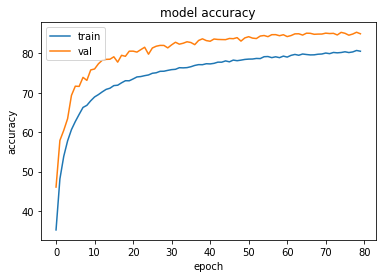

In [14]:
args.cmd = 'train'
if args.cmd == 'train':
    print("Model training starts on {} dataset".format(args.dataset))
    if L2:
        weight_decay = args.l2_weight_decay
    else:
        weight_decay = 0

    acc = 0
    val_acc = 0
    test_loss = 0
    #EPOCHS = args.epochs
    EPOCHS = 80
    init_learning_rate = 0.07
    gamma= (init_learning_rate - (0.1/EPOCHS))/init_learning_rate
    optimizer = optim.SGD(model.parameters(), lr=init_learning_rate, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    last_best = ''
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch + 1)
        print('LR:', optimizer.param_groups[0]['lr'])
        acc = train.train(model, device, train_loader, optimizer, epoch)
        val_acc, test_loss, model_name = test.test(model, device, test_loader, optimizer, epoch)
        scheduler.step() 
        last_best = last_best if (model_name == '') else model_name
    utils.plot_acc()

### model-prediction & mislabelled images

Model inference starts on CIFAR10  dataset
Loaded the best model: CIFAR10_model_epoch-79_L1-1_L2-0_val_acc-85.39.h5 from last training session
The confusion-matrix and classification-report for this model are:
[[912  12  19   5   7   1   1   6  25  12]
 [  9 940   1   3   0   1   1   2  16  27]
 [ 52   1 789  25  39  27  38  24   1   4]
 [ 20   4  49 670  40 127  46  27  10   7]
 [ 15   1  49  17 829  25  26  33   3   2]
 [  9   2  28  97  27 779  12  40   2   4]
 [  6   3  21  27  10  13 908   7   3   2]
 [ 12   2  12  19  18  24   1 907   1   4]
 [ 45  13   6   3   2   2   1   2 916  10]
 [ 29  52   4   6   0   2   0   5  13 889]]
              precision    recall  f1-score   support

    airplane       0.82      0.91      0.86      1000
  automobile       0.91      0.94      0.93      1000
        bird       0.81      0.79      0.80      1000
         cat       0.77      0.67      0.72      1000
        deer       0.85      0.83      0.84      1000
         dog       0.78      0.78 

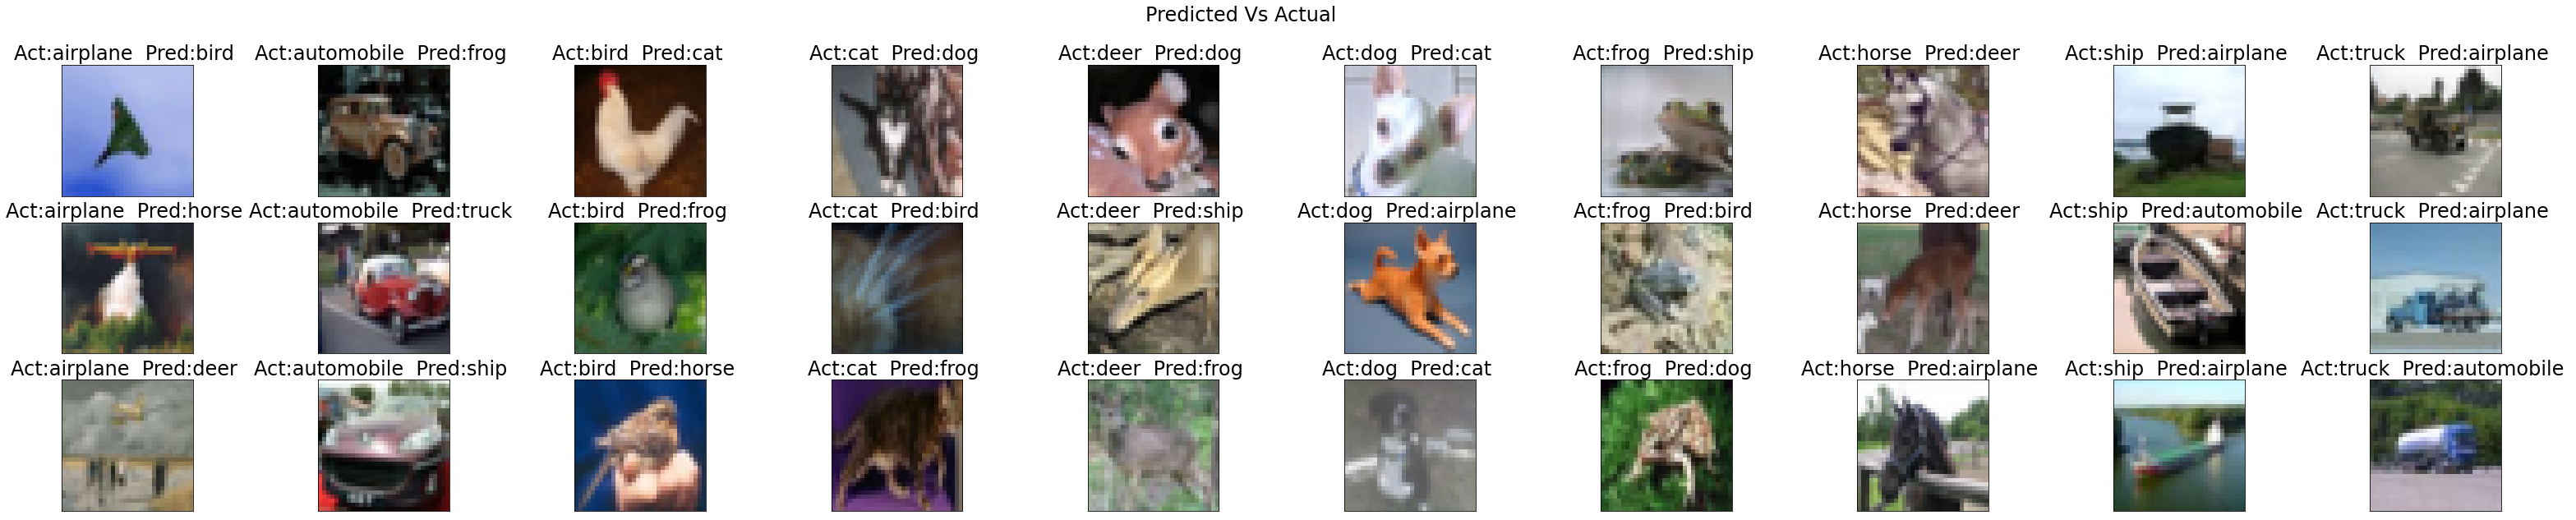

In [17]:
print("Model inference starts on {}  dataset".format(args.dataset))
print("Loaded the best model: {} from last training session".format(last_best))
model = utils.load_model(EVA8_session6_assignment_model(), device, model_name=last_best)
y_test = np.array(test_dataset.targets)
print("The confusion-matrix and classification-report for this model are:")
y_pred = utils.model_pred(model, device, y_test, test_dataset)
x_test = test_dataset.data
utils.display_mislabelled(model, device, x_test, y_test.reshape(-1, 1), y_pred, test_dataset, title_str='Predicted Vs Actual')